In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#### Feature selection – variance

In [2]:
from sklearn.datasets import load_wine
data = load_wine()
X = data.data
y = data.target

df = pd.DataFrame(X)

##### Fairer Comparison of Variance With Feature Normalization
Often, it is not fair to compare the variance of a feature to another. The reason is that as the values in the distribution get bigger, the variance grows exponentially. In other words, the variances will not be on the same scale.

In [3]:
df.describe()

0           1           2           3           4           5   \
count  178.000000  178.000000  178.000000  178.000000  178.000000  178.000000   
mean    13.000618    2.336348    2.366517   19.494944   99.741573    2.295112   
std      0.811827    1.117146    0.274344    3.339564   14.282484    0.625851   
min     11.030000    0.740000    1.360000   10.600000   70.000000    0.980000   
25%     12.362500    1.602500    2.210000   17.200000   88.000000    1.742500   
50%     13.050000    1.865000    2.360000   19.500000   98.000000    2.355000   
75%     13.677500    3.082500    2.557500   21.500000  107.000000    2.800000   
max     14.830000    5.800000    3.230000   30.000000  162.000000    3.880000   

               6           7           8           9           10          11  \
count  178.000000  178.000000  178.000000  178.000000  178.000000  178.000000   
mean     2.029270    0.361854    1.590899    5.058090    0.957449    2.611685   
std      0.998859    0.124453    0.572359    2.318286    0.228572    0.709990   
min      0.340000    0.130000    0.410000    1.280000    0.480000    1.270000   
25%      1.205000    0.270000    1.250000    3.220000    0.782500    1.937500   
50%      2.135000    0.340000    1.555000    4.690000    0.965000    2.780000   
75%      2.875000    0.437500    1.950000    6.200000    1.120000    3.170000   
max      5.080000    0.660000    3.580000   13.000000    1.710000    4.000000   

                12  
count   178.000000  
mean    746.893258  
std     314.907474  
min     278.000000  
25%     500.500000  
50%     673.500000  
75%     985.000000  
max    1680.000000

<AxesSubplot:>

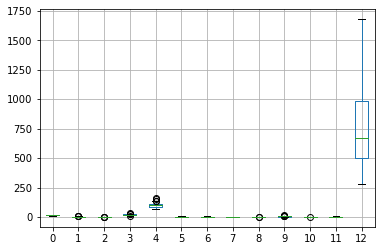

In [4]:
df.boxplot()

The above features all have different medians, quartiles, and ranges — completely different distributions. We cannot compare these features to each other.

One method we can use is scale all features using the Robust Scaler which is not highly affected by outliers:

In [5]:
from sklearn.preprocessing import RobustScaler

transformer = RobustScaler().fit(X)
X_scaled = transformer.transform(X)
df_scaled = pd.DataFrame(X_scaled)

This method ensures that all variances are on the same scale:

In [6]:
df_scaled.var()

0     0.381132
1     0.569766
2     0.623277
3     0.603174
4     0.565067
5     0.350252
6     0.357746
7     0.552056
8     0.668561
9     0.605204
10    0.458666
11    0.331842
12    0.422453
dtype: float64

In [7]:
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(threshold=0.35)
# Learn variances from X_scaled
_ = selector.fit(X_scaled)
# Get a mask (or integer index if indices=True is set) of the features selected
mask = selector.get_support()
print(mask)
# get the subset of features selected
X_transformed = X_scaled[:, mask]

[ True  True  True  True  True False  True  True  True  True  True False
  True]


#### Feature selection – importance

Feature ranking:
1. feature 12 (0.240954)
2. feature 11 (0.162438)
3. feature 6 (0.149339)
4. feature 0 (0.127384)
5. feature 9 (0.125520)
6. feature 10 (0.072550)
7. feature 5 (0.031640)
8. feature 1 (0.027186)
9. feature 4 (0.021927)
10. feature 3 (0.013679)
11. feature 8 (0.012320)
12. feature 2 (0.010575)
13. feature 7 (0.004489)


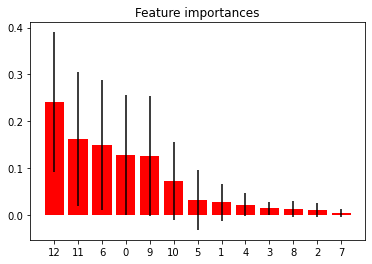

In [8]:
# we use the scaled features
X = X_scaled
y = data.target

# Feature Importance 1
# Use ensemble method: The goal of ensemble methods is to combine the 
# predictions of several base estimators built with a given learning algorithm 
# in order to improve generalizability / robustness over a single estimator.
# http://scikit-learn.org/stable/modules/ensemble.html
from sklearn.ensemble import ExtraTreesClassifier
# Build an estimator (forest of trees) and compute the feature importances
# n_estimators = number of trees in forest
estimator = ExtraTreesClassifier(n_estimators=100, max_features=13, random_state=0)
estimator.fit(X,y)
# Lets get the feature importances. Features with high importance score higher.
importances = estimator.feature_importances_
std = np.std([tree.feature_importances_ for tree in estimator.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

In [9]:
# Feature Importance 2
from sklearn.feature_selection import RFE
estimator = ExtraTreesClassifier(n_estimators=100, random_state=0)
# keep the 5 most informative features
selector = RFE(estimator, n_features_to_select=5, step=1)
selector = selector.fit(X, y)
print(list(selector.support_))
print(list(selector.ranking_))

[True, False, False, False, False, False, True, False, False, True, False, True, True]
[1, 3, 8, 5, 6, 4, 1, 9, 7, 1, 2, 1, 1]


#### Feature selection – correlation

<AxesSubplot:>

<Figure size 432x288 with 0 Axes>

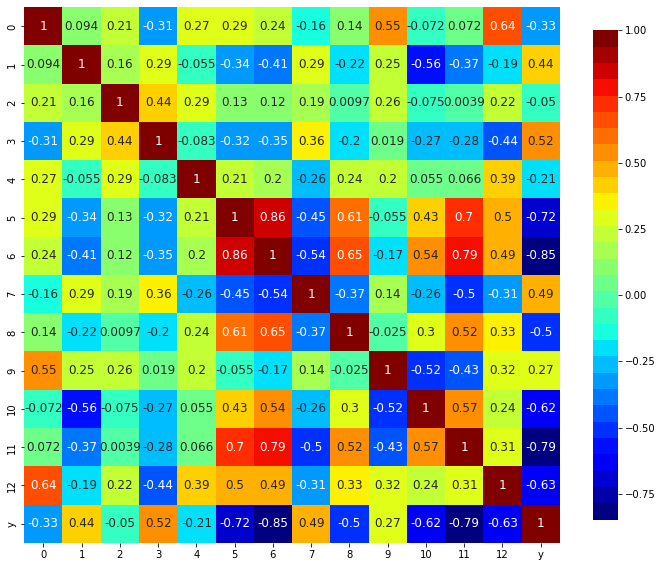

In [10]:
import seaborn as sns
from matplotlib import cm as cm

plt.figure()
# convert list of wine observations to a pandas dataframe 
# num of columns = num of features
# find pairwise correlation of columns
# default correlation method = pearson
df = pd.DataFrame(X)
df['y'] = y
corr = df.corr(method='pearson')
cmap = cm.get_cmap('jet', 30)
_, ax = plt.subplots( figsize = ( 12 , 10 ) )
sns.heatmap(corr, cmap = cmap, square=True, cbar_kws={ 'shrink' : .9 }, ax=ax, annot = True, annot_kws = { 'fontsize' : 12 }, xticklabels=corr.columns, yticklabels=corr.columns)

#### Feature selection - Forward selection/Backward elimination

In [11]:
# Example 1
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=4)

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
# Sequential Forward Selection
sfs = SFS(knn, 
           k_features=5, 
           forward=True, 
           floating=False, 
           verbose=2,
           scoring='accuracy',
           cv=10)

sfs = sfs.fit(X, y)

print('\nSequential Forward Selection (k=5):')
print('Selected features:',sfs.k_feature_idx_)
print('Prediction score:',sfs.k_score_)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    0.2s finished

[2022-10-06 12:27:30] Features: 1/5 -- score: 0.7696078431372548[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.2s finished

[2022-10-06 12:27:30] Features: 2/5 -- score: 0.9212418300653595[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.2s finished

[2022-10-06 12:27:30] Features: 3/5 -- score: 0.9493464052287581[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 


Sequential Forward Selection (k=5):
Selected features: (1, 4, 6, 9, 12)
Prediction score: 0.9663398692810456


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.1s finished

[2022-10-06 12:27:31] Features: 5/5 -- score: 0.9663398692810456

In [12]:
# Example 2
# Sequential Backward Selection
sbs = SFS(knn, 
          k_features=5, 
          forward=False, 
          floating=False, 
          scoring='accuracy',
          cv=10)
sbs = sbs.fit(X, y)

print('\nSequential Backward Selection (k=5):')
print('Selected features:',sbs.k_feature_idx_)
print('Prediction (CV) score:',sbs.k_score_)


Sequential Backward Selection (k=5):
Selected features: (0, 2, 8, 9, 12)
Prediction (CV) score: 0.9607843137254901


In [13]:
# Example 3
print(pd.DataFrame.from_dict(sbs.get_metric_dict()).T)

                                   feature_idx  \
13  (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12)   
12     (0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12)   
11        (0, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12)   
10            (0, 2, 3, 5, 6, 7, 8, 9, 10, 12)   
9                (0, 2, 3, 5, 7, 8, 9, 10, 12)   
8                   (0, 2, 3, 5, 8, 9, 10, 12)   
7                      (0, 2, 3, 8, 9, 10, 12)   
6                          (0, 2, 3, 8, 9, 12)   
5                             (0, 2, 8, 9, 12)   

                                            cv_scores avg_score  \
13  [0.8888888888888888, 0.9444444444444444, 0.888...  0.937908   
12  [0.8333333333333334, 0.9444444444444444, 0.888...  0.949673   
11  [0.9444444444444444, 0.9444444444444444, 0.944...   0.96634   
10  [0.9444444444444444, 0.9444444444444444, 0.944...  0.971895   
9   [0.9444444444444444, 0.9444444444444444, 1.0, ...  0.971895   
8   [0.9444444444444444, 0.8888888888888888, 1.0, ...  0.977778   
7   [0.9444444444444444, 0.888

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    0.2s finished

[2022-10-06 12:27:33] Features: 1/5 -- score: 0.7696078431372548[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.3s finished

[2022-10-06 12:27:33] Features: 2/5 -- score: 0.9212418300653595[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.2s finished

[2022-10-06 12:27:34] Features: 3/5 -- score: 0.9493464052287581[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 

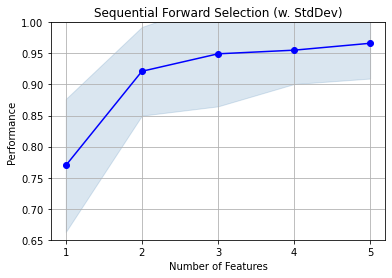

In [14]:
# Example 4
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

sfs = SFS(knn, 
          k_features=5, 
          forward=True, 
          floating=False, 
          scoring='accuracy',
          verbose=2,
          cv=10)

sfs = sfs.fit(X, y)

fig1 = plot_sfs(sfs.get_metric_dict(), kind='std_dev')

plt.ylim([0.65, 1])
plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()
plt.show()

best combination (ACC: 0.972): (1, 4, 6, 9, 10, 11, 12)

all subsets:
 {1: {'feature_idx': (6,), 'cv_scores': array([0.61111111, 0.66666667, 0.88888889, 0.88888889, 0.72222222,
       0.66666667, 0.94444444, 0.77777778, 0.82352941, 0.70588235]), 'avg_score': 0.7696078431372548, 'feature_names': ('6',)}, 2: {'feature_idx': (6, 9), 'cv_scores': array([0.77777778, 0.83333333, 0.88888889, 0.94444444, 1.        ,
       0.94444444, 1.        , 1.        , 0.88235294, 0.94117647]), 'avg_score': 0.9212418300653595, 'feature_names': ('6', '9')}, 3: {'feature_idx': (4, 6, 9), 'cv_scores': array([0.72222222, 1.        , 0.94444444, 1.        , 1.        ,
       0.94444444, 1.        , 1.        , 0.88235294, 1.        ]), 'avg_score': 0.9493464052287581, 'feature_names': ('4', '6', '9')}, 4: {'feature_idx': (4, 6, 9, 12), 'cv_scores': array([0.83333333, 1.        , 0.88888889, 0.94444444, 1.        ,
       1.        , 1.        , 0.94444444, 0.94117647, 1.        ]), 'avg_score': 0.95522875816

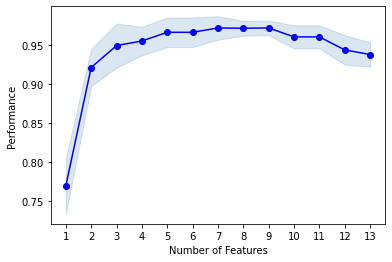

In [15]:
# Example 5
knn = KNeighborsClassifier(n_neighbors=4)

sfs_range = SFS(estimator=knn, 
           k_features=(2, 13),
           forward=True, 
           floating=False, 
           scoring='accuracy',
           cv=10)

sfs_range = sfs_range.fit(X, y)

print('best combination (ACC: %.3f): %s\n' % (sfs_range.k_score_, sfs_range.k_feature_idx_))
print('all subsets:\n', sfs_range.subsets_)
plot_sfs(sfs_range.get_metric_dict(), kind='std_err');

#### Feature Extraction

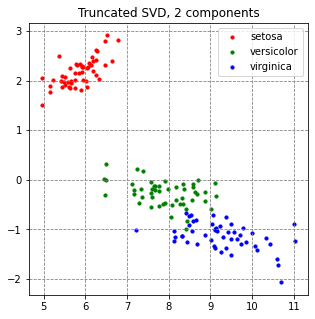

TruncatedSVD explained variance ratio (first two components): [0.52875361 0.44845576]


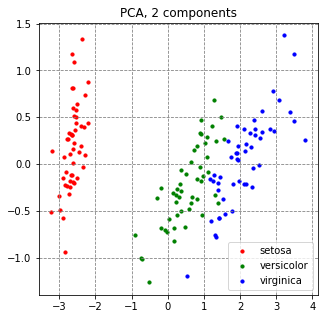

PCA explained variance ratio (first two components): [0.92461872 0.05306648]


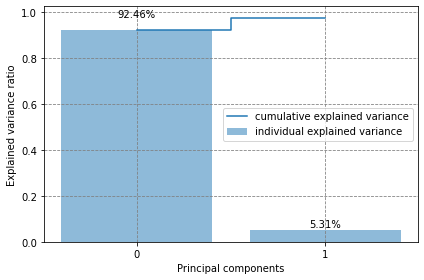

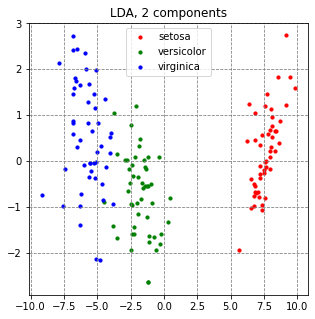

LDA explained variance ratio (first two components): [0.9912126 0.0087874]
PCA explained variance ratio (first four components): [0.80582318 0.16305197 0.02134861 0.00695699]


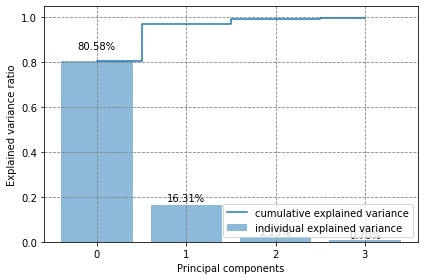

In [16]:
from sklearn.datasets import load_iris

iris = load_iris()
iris_data = iris.data
iris_target = iris.target
num_of_classes = len(set(iris_target))

def print_scatter_plot(features, target, title):
    # figure size
    plt.figure(figsize=(5,5))
    # customize gridness
    plt.rc('grid', linestyle="--", color='gray')
    colors = ['r', 'g', 'b', 'm', 'c']
    for i in range(num_of_classes):
        ind = [j for j in range(target.size) if target[j] == i]
        # plot the data observations
        # Colormaps reference: http://matplotlib.org/examples/color/colormaps_reference.html
        plt.scatter(features[ind,0], features[ind,1], c=colors[i], s=10, label='%s'%iris.target_names[i])
    plt.title(title+', 2 components')
    # print the grid
    plt.grid(True)
    # print the lagend
    plt.legend(loc='best')
    plt.show()        

def print_variance_explained_plot(obj, n_components):
    cum_var_exp = np.cumsum(obj.explained_variance_ratio_)
    fig, ax = plt.subplots(figsize=(6, 4))
    bars = ax.bar(range(n_components), obj.explained_variance_ratio_, alpha=0.5, align='center',
                label='individual explained variance')
    # show percentage of explained variance on top of each bar
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., 1.05*height, '%.2f%%' % (height*100), 
                ha='center', va='bottom')
    plt.step(range(n_components), cum_var_exp, where='mid',
                 label='cumulative explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.xticks( range(n_components) )
    plt.grid(True)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()
    
# Truncated SVD
from sklearn.decomposition import TruncatedSVD
tsvd = TruncatedSVD(2)
iris_tsvd = tsvd.fit_transform(iris_data)
print_scatter_plot(iris_tsvd, iris_target, 'Truncated SVD')
# Percentage of variance explained for each components
print('TruncatedSVD explained variance ratio (first two components): %s'
      % str(tsvd.explained_variance_ratio_))

# PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
iris_pca = pca.fit_transform(iris_data)
print_scatter_plot(iris_pca, iris_target, 'PCA')
# Percentage of variance explained for each components
print('PCA explained variance ratio (first two components): %s'
      % str(pca.explained_variance_ratio_))
print_variance_explained_plot(pca,2)

# Linear Discriminant Analysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis(n_components=2)
iris_lda = lda.fit(iris_data, iris_target).transform(iris_data)
print_scatter_plot(iris_lda, iris_target, 'LDA')
# Percentage of variance explained for each components
print('LDA explained variance ratio (first two components): %s'
      % str(lda.explained_variance_ratio_))

# PCA on a regression problem
from sklearn.datasets import load_boston
boston = load_boston()
n_components = 4
pca = PCA(n_components=n_components)
# train model with data to get the variance expained
pca.fit(boston.data)
# Percentage of variance explained for each components
print('PCA explained variance ratio (first four components): %s'
      % str(pca.explained_variance_ratio_))
print_variance_explained_plot(pca, n_components)